In [7]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
DB_PATH = os.path.abspath(os.path.join('../data/validation_database.sqlite3'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from PIL import Image
import altair as alt
import pandas as pd
from datetime import datetime

In [8]:
from src.interfaces.database import SQLiteProxy

In [9]:
db = SQLiteProxy(DB_PATH)
db.get_no_cones().clean()

for run_name in db.get_runs().read(projection=['name']):
    cones = db.get_cones().read(run_name=run_name[0], projection=['x', 'y'])
    no_cones = db.get_no_cones().read(run_name=run_name[0], projection=['x', 'y'])

    cones_df = pd.DataFrame(cones, columns=['x', 'y'])
    no_cones_df = pd.DataFrame(no_cones, columns=['x', 'y'])

    map_plot = (
        alt.Chart(cones_df).mark_circle(color='blue').encode(x='x', y='y') +
        alt.Chart(no_cones_df).mark_circle(color='red').encode(x='x', y='y')
    ).properties(
        title=run_name
    )

    display(map_plot)
    

/home/usuaris/imatge/pau.matas/.conda/envs/.env/lib/python3.10/site-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

/tmp/ipykernel_26767/727693305.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
/tmp/ipykernel_26767/727693305.py:14: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  image = Image.frombytes("RGBA", (w, h), buf.tostring())


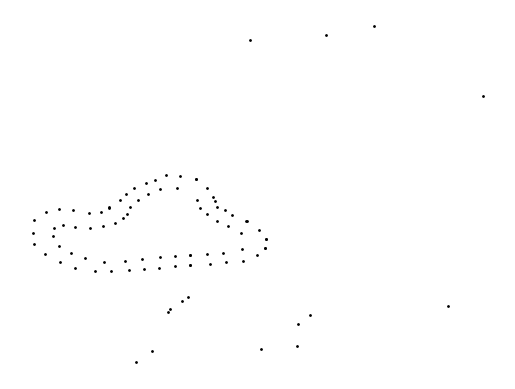

In [10]:
def list_to_input(detected_cones: list, circuit_id: str = "0"):
    fig, ax = plt.subplots()
    hc = np.array(detected_cones)
    ax.scatter(hc[:,0], hc[:,1], color=(0,0,0,1), s=1)
    plt.axis("off")
    # draw the renderer
    fig.canvas.draw()
    # Get the RGBA buffer from the figure
    w, h = fig.canvas.get_width_height()
    buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (w, h, 4)
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll(buf, 3, axis=2)
    image = Image.frombytes("RGBA", (w, h), buf.tostring())
    image = np.asarray(image)
    label = np.where(image > 128, 1.0, 0)
    label = np.uint8(label)
    pkl.dump(label, open(f"out/real-label{circuit_id}.pkl", "wb"))

def all_circuits_list_to_input():
    for run_name in db.get_runs().read(projection=['name']):
        cones = db.get_cones().read(run_name=run_name[0], projection=['x', 'y'])
        no_cones = db.get_no_cones().read(run_name=run_name[0], projection=['x', 'y'])
        detected_cones = cones + no_cones
        list_to_input(detected_cones, run_name[0])

all_circuits_list_to_input()